In [1]:
import sys
sys.path.append("/home/ricky/Documents/from_work/git/NMR_FF_tools/relaxation_times/")
sys.path.insert(1, '/home/ricky/Documents/from_work/git/charged_molecules_binding/simulations_list/')

sys.path.append("../")

import numpy as np
import relaxation_times as rt
import manage_files as mf
import plotting as pt
import matplotlib.pyplot as plt
import os
import re
import yaml
import gc
import math
import warnings

from scipy.optimize import minimize

import SRT_optimization as srt

import random
from datetime import date
today = date.today()

import fnmatch

gc.collect()

/home/ricky/anaconda3/envs/all3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ricky/anaconda3/envs/all3/lib/python3.8/site-packages/MDAnalysis/coordinates/chemfiles.py:59: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")


0

<H3>Calculates the possible minima and maxima of SRT for the given effective time</H3>
changing now to R1, R2....

In [10]:
magn_field_MHz=400 # for values in MHz
x=np.logspace((-20),(-3),200) # set of timescales used for optimization
x2=np.logspace((-12),(-7),100) # set of timescales for which the extremes are searched for

In [11]:
from scipy.optimize import minimize

gammaD=41.695*10**6; #r*s^(-1)*T^(-1)
gammaH=267.513*10**6;
gammaC=67.262*10**6;
gammaN=-27.166*10**6;

R1=True
R2=True
NOE=True

mu = 4 * np.pi * 10**(-7) #magnetic constant of vacuum permeability
h_planck = 1.055 * 10**(-34); #reduced Planck constant
rN = 0.101 * 10**(-9); # average cubic length of N-H bond
d = 1 * (mu * gammaN * gammaH * h_planck) / (4 * np.pi * rN**3); # dipolar coupling constant



magnetic_field=magn_field_MHz*2*np.pi/gammaH*10**6

wh = gammaH * magnetic_field 
wn = gammaN * magnetic_field 




#x=np.logspace((-9),(-8),3) # x-akselin rajat


# Initial guess for w
initial_w = np.zeros_like(x) / len(x)

min_values_R1=[]
max_values_R1=[]
one_time_values_R1=[]
optimized_maxima_R1=[]
optimized_minima_R1=[]

min_values_R2=[]
max_values_R2=[]
one_time_values_R2=[]
optimized_maxima_R2=[]
optimized_minima_R2=[]

min_values_NOE=[]
max_values_NOE=[]
one_time_values_NOE=[]
optimized_maxima_NOE=[]
optimized_minima_NOE=[]

# Bounds for w_i (allowing values between 0 and 1)
bounds = [(0, 1) for _ in range(len(x))]




#x2=np.logspace((-9),(-8),10)
for b in x2:

    # Constraints
    constraints = [{'type': 'eq', 'fun': srt.constraint},
                   {'type': 'eq', 'fun': srt.constraint_sum, 'args': (x, b)},
                   {'type': 'ineq', 'fun': srt.constraint_positive}]


    
    
    if R1:
        # Solve the maximization of T1 
        result = minimize(srt.R1_function_max, initial_w, args=(x,magnetic_field), constraints=constraints, bounds=bounds)
        min_values_R1.append(-result.fun)   
        optimized_w = result.x
        optimized_minima_R1.append(optimized_w)



        # Solve the minimization of T1
        result = minimize(srt.R1_function_min, initial_w, args=(x,magnetic_field), constraints=constraints, bounds=bounds)
        max_values_R1.append(result.fun)    
        optimized_w = result.x
        optimized_maxima_R1.append(optimized_w)

        one_time_values_R1.append(srt.R1_function_min(1,b,magnetic_field))
        
        

    if R2:
        # Solve the maximization of T2 
        result = minimize(srt.R2_function_max, initial_w, args=(x,magnetic_field), constraints=constraints, bounds=bounds)
        min_values_R2.append(-result.fun)   
        optimized_w = result.x
        optimized_minima_R2.append(optimized_w)



        # Solve the minimization of T2
        result = minimize(srt.R2_function_min, initial_w, args=(x,magnetic_field), constraints=constraints, bounds=bounds)
        max_values_R2.append(result.fun)    
        optimized_w = result.x
        optimized_maxima_R2.append(optimized_w)

        one_time_values_R2.append(srt.R2_function_min(1,b,magnetic_field))
        
        

        
    if NOE:
        # Solve the maximization of hetNOE
        #result = minimize(srt.NOE_function_max, initial_w, args=(x,magnetic_field), constraints=constraints, bounds=bounds)
        #min_values_NOE.append(result.fun)   
        #optimized_w = result.x
        #optimized_minima_NOE.append(optimized_w)



        # Solve the minimization of hetNOE
        #result = minimize(srt.NOE_function_min, initial_w, args=(x,magnetic_field), constraints=constraints, bounds=bounds)
        #max_values_NOE.append(result.fun)    
        #optimized_w = result.x
        #optimized_maxima_NOE.append(optimized_w)
    

        one_time_values_NOE.append(srt.NOE_function_min(1,b,magnetic_field))
        
        
if R1:
    xf = np.concatenate([x2,x2[::-1]])
    yf = np.concatenate([min_values_R1,max_values_R1[::-1]])

    data_to_save=np.array([xf,yf])
    np.savetxt("extremes_of_Redfield/R1_limits_"+str(magn_field_MHz)+".dat",data_to_save)
        
    data_to_save=np.array([x2,one_time_values_R1])
    np.savetxt("1timescale_data/R1_1timescale_"+str(magn_field_MHz)+".dat",data_to_save)

if R2:
    xf = np.concatenate([x2,x2[::-1]])
    yf = np.concatenate([min_values_R2,max_values_R2[::-1]])

    data_to_save=np.array([xf,yf])
    np.savetxt("extremes_of_Redfield/R2_limits_"+str(magn_field_MHz)+".dat",data_to_save)
        
    data_to_save=np.array([x2,one_time_values_R2])
    np.savetxt("1timescale_data/R2_1timescale_"+str(magn_field_MHz)+".dat",data_to_save)

if NOE:
    data_to_save=np.array([x2,one_time_values_NOE])
    np.savetxt("1timescale_data/hetNOE_1timescale_"+str(magn_field_MHz)+".dat",data_to_save)


<H3>Load in the simulation data</H3>

In [2]:
output_path_relax="../../../CorysPeptides/relax_times_yamls/protein/raw_data/"            # folder to save spin relaxation times yaml files, 
output_path_timescales="../../../CorysPeptides/timescales_yamls/protein/raw_data/"  # folder to save timescale yaml files
 
relaxation_yamls_prot,timescales_yamls_prot=mf.load_yaml_files(output_path_relax,output_path_timescales)


output_path_relax="../../../CorysPeptides/sds_vs_peptide/timescales_yaml_efstathia/"            # folder to save spin relaxation times yaml files, 
                                      # defined above or redefine here 
output_path_timescales="../../../CorysPeptides/sds_vs_peptide/timescales_yaml_efstathia/"  # folder to save timescale yaml files
                                      # defined above or redefine here

relaxation_yamls_efstathia,timescales_yamls_efsthatia=mf.load_yaml_files(output_path_relax,output_path_timescales)


output_path_relax="../../../CorysPeptides/sds_vs_peptide/timescales_yaml_amanda/calmodulin/"            # folder to save spin relaxation times yaml files, 
                                      # defined above or redefine here 
output_path_timescales="../../../CorysPeptides/sds_vs_peptide/timescales_yaml_amanda/calmodulin/"  # folder to save timescale yaml files
                                      # defined above or redefine here

relaxation_yamls_calmodulin,timescales_yamls_calmodulin=mf.load_yaml_files(output_path_relax,output_path_timescales)


output_path_relax="../../../CorysPeptides/sds_vs_peptide/timescales_yaml_amanda/CDNF/"            # folder to save spin relaxation times yaml files, 
                                      # defined above or redefine here 
output_path_timescales="../../../CorysPeptides/sds_vs_peptide/timescales_yaml_amanda/CDNF/"  # folder to save timescale yaml files
                                      # defined above or redefine here

relaxation_yamls_CDNF,timescales_yamls_CDNF=mf.load_yaml_files(output_path_relax,output_path_timescales)



output_path_relax="../../../CorysPeptides/sds_vs_peptide/timescales_yaml_amanda/EN2/"            # folder to save spin relaxation times yaml files, 
                                      # defined above or redefine here 
output_path_timescales="../../../CorysPeptides/sds_vs_peptide/timescales_yaml_amanda/EN2/"  # folder to save timescale yaml files
                                      # defined above or redefine here

relaxation_yamls_EN2,timescales_yamls_EN2=mf.load_yaml_files(output_path_relax,output_path_timescales)



output_path_relax="../../../CorysPeptides/sds_vs_peptide/timescales_yaml_amanda/musMANF/"            # folder to save spin relaxation times yaml files, 
                                      # defined above or redefine here 
output_path_timescales="../../../CorysPeptides/sds_vs_peptide/timescales_yaml_amanda/musMANF/"  # folder to save timescale yaml files
                                      # defined above or redefine here

relaxation_yamls_musMANF,timescales_yamls_musMANF=mf.load_yaml_files(output_path_relax,output_path_timescales)



output_path_relax="../../../CorysPeptides/sds_vs_peptide/timescales_yaml_amanda/tonB/"            # folder to save spin relaxation times yaml files, 
                                      # defined above or redefine here 
output_path_timescales="../../../CorysPeptides/sds_vs_peptide/timescales_yaml_amanda/tonB/"  # folder to save timescale yaml files
                                      # defined above or redefine here

relaxation_yamls_tonB,timescales_yamls_tonB=mf.load_yaml_files(output_path_relax,output_path_timescales)

Spin relaxation data exist for:

   * GWALP_dimer_micelle_45SDS_CHARMM_310K_Na_Neut_OPC_replica1
   * eElab_micelle_40SDS_CHARMM_310K_Na_Neut_OPC_replica2
   * hMff_micelle_50SDS_CHARMM_310K_Na_Neut_OPC_23500water_replica1
   * GWALP_monomer_micelle_40SDS_CHARMM_310K_Na_Neut_OPC_replica1
   * GWALP_monomer_micelle_50SDS_CHARMM_310K_Na_Neut_OPC_replica1
   * hMff_micelle_50SDS_CHARMM_310K_Na_Neut_OPC_73800water_replica1
   * yFis1_micelle_50SDS_CHARMM_310K_Na_Neut_OPC_replica3
   * hMff_micelle_60SDS_CHARMM_310K_Na_Neut_OPC_replica3
   * hMff_micelle_45SDS_CHARMM_310K_Na_Neut_OPC_replica1
   * hMff_micelle_60SDS_CHARMM_310K_Na_Neut_OPC_replica2
   * GWALP_dimer_micelle_60SDS_CHARMM_310K_Na_Neut_OPC_replica1
   * eYqjD_micelle_50SDS_CHARMM_310K_Na_Neut_OPC_replica1
   * GWALP_monomer_micelle_70SDS_CHARMM_310K_Na_Neut_OPC_replica1
   * hMff_micelle_45SDS_CHARMM_310K_Na_Neut_OPC_replica2
   * eElaB_dimer_50SDS_310K_CHARMM_Na_Neut_OPC_Water_Model
   * GWALP_dimer_micelle_70SDS_CHARMM_310K_N


 
Timescales exist for:

   * ome_local_sandelam_Desktop_CDNF_md2_amberff03ws_model2_unoriented
   * edia_sandelam_sandelamstorage2_sandelam_CDNF_amber99SB-disp_CDNF_amber99SB-disp_model6_unoriented
   * edia_sandelam_sandelamstorage2_sandelam_CDNF_amber99SB-disp_CDNF_amber99SB-disp_model4_unoriented
   * edia_sandelam_sandelamstorage2_sandelam_CDNF_DESamber_CDNF_DESamber_model6_unoriented
   * edia_sandelam_sandelamstorage2_sandelam_CDNF_corrected_md2_amber99SB-ILDN_unoriented
   * edia_sandelam_sandelamstorage2_sandelam_CDNF_corrected_amber99SB-disp_unoriented
   * edia_sandelam_sandelamstorage2_sandelam_CDNF_md2_amber99SB-ILDN_model8_unoriented
   * ome_local_sandelam_Desktop_CDNF_md2_amberff03ws_model4_unoriented
   * edia_sandelam_sandelamstorage2_sandelam_CDNF_DESamber_CDNF_DESamber_model4_unoriented
   * edia_sandelam_sandelamstorage2_sandelam_CDNF_amber99SB-disp_CDNF_amber99SB-disp_model2_unoriented
   * edia_sandelam_sandelamstorage2_sandelam_CDNF_md2_amber99SB-ILDN_model1_un

<H3>Save data at iven field from simulations</H3>

In [12]:
magn_field_MHz=400 # for values in MHz
magnetic_field=magn_field_MHz*2*np.pi/gammaH*10**6




save_labels=["small_peptides",
       "peptides_SDSmicelles",
       "Calmodulin",
       "CDNF",
       "EN2",
       "musMANF",
       "TonB"]

for i,timescales in enumerate([timescales_yamls_efsthatia,timescales_yamls_prot,
                              timescales_yamls_calmodulin,timescales_yamls_CDNF,
                              timescales_yamls_EN2,timescales_yamls_musMANF,
                              timescales_yamls_tonB]):
    
    eff_times=[]
    R1s=[]
    R2s=[]
    hetNOEs=[]
    
    for sim in timescales:        
        #check if timesales exist
        for ana2 in timescales[sim]:
            info=timescales[sim][ana2]["info"]
            #select the analysis that we used
            if (info["04_smallest_corr_time_[s]"]==10**(-12) and
                info["05_biggest_corr_time_[s]"]==10**(-7) and
                info["03_N_exp_to_fit"]==100 and
                info["00_nuclei"]=='15N'):

                for bond in timescales[sim][ana2]["results"]["Coeff"]:
                    if timescales[sim][ana2]["results"]["Coeff"][bond][-1]>0:
                        timescales[sim][ana2]["results"]["Coeff"][bond][-1]=0
                    
                    coeff=timescales[sim][ana2]["results"]["Coeff"][bond]
                    ctime=timescales[sim][ana2]["results"]["Ctime"]
                    effTime=sum(t*k for t,k in zip(coeff,ctime))*10**9

                    T1,T2,NOE=rt.get_relaxation_N(magnetic_field,coeff,ctime,0)
                    
                    eff_times.append(effTime)
                    R1s.append(1/T1)
                    R2s.append(1/T2)
                    hetNOEs.append(NOE)
    
    
    data_to_save=np.array([eff_times,R1s,R2s,hetNOEs])
    np.savetxt("simulation_SRT_vs_effTime/"+save_labels[i]+"_"+str(magn_field_MHz)+".dat",data_to_save)
                    

<H3>Plot the main plot</H3>

In [39]:
# data is saved in the form [[effTimes],[R1],[R2],[hetNOE]]

systems={}
for system in save_labels:
    systems[system]=np.loadtxt("simulation_SRT_vs_effTime/"+system+"_"+str(magn_field_MHz)+".dat")
    

# data is saved in the form [[effTimes,effTime[-1:0]],[R1limits_min,R1limits_max[-1:0]]]
# resp [[effTimes,effTime[-1:0]],[R2limits_min,R1limits_max[-1:0]]] - the data

limits={}
limits["R1"]=np.loadtxt("extremes_of_Redfield/R1_limits_"+str(magn_field_MHz)+".dat")
limits["R2"]=np.loadtxt("extremes_of_Redfield/R2_limits_"+str(magn_field_MHz)+".dat")


# data is saved as [[effTimes],[R1]], [[effTimes],[R2]], [[effTimes],[hetNOE]] 

oneTime={}
oneTime["R1"]=np.loadtxt("1timescale_data/R1_1timescale_"+str(magn_field_MHz)+".dat")
oneTime["R2"]=np.loadtxt("1timescale_data/R2_1timescale_"+str(magn_field_MHz)+".dat")
oneTime["hetNOE"]=np.loadtxt("1timescale_data/hetNOE_1timescale_"+str(magn_field_MHz)+".dat")

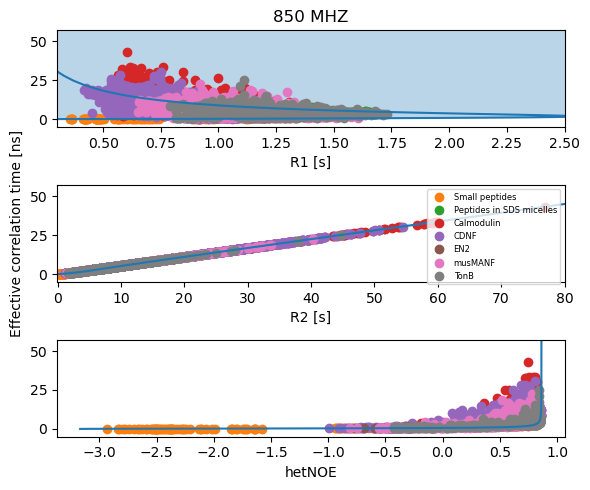

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(3,sharex=False)
plt.rcParams["figure.figsize"] = [6, 5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 10})
fig.patch.set_facecolor('xkcd:white')

labels=["Small peptides",
       "Peptides in SDS micelles",
       "Calmodulin",
       "CDNF",
       "EN2",
       "musMANF",
       "TonB"]


for i,system in enumerate(systems):    
    ax1.plot(systems[system][1],systems[system][0],"o",c="C"+str(1+i))
    ax2.plot(systems[system][2],systems[system][0],"o",c="C"+str(1+i),label=labels[i])
    ax3.plot(systems[system][3],systems[system][0],"o",c="C"+str(1+i))

                

                        

ax1.plot(oneTime["R1"][1],oneTime["R1"][0]*10**9,"-")
ax1.fill(limits["R1"][1], limits["R1"][0]*10**9,  alpha=0.3)
ax2.plot(oneTime["R2"][1],oneTime["R2"][0]*10**9,"-")
ax2.fill(limits["R2"][1], limits["R2"][0]*10**9,  alpha=0.3)
ax3.plot(oneTime["hetNOE"][1],oneTime["hetNOE"][0]*10**9,"-")


ax1.set_xlabel("R1 [s]")
ax2.set_xlabel("R2 [s]")
ax3.set_xlabel("hetNOE")                        
ax2.set_ylabel("Effective correlation time [ns]")


ax1.set_xlim(0.3,2.5)
ax1.set_ylim(-5,57)
ax2.set_xlim(-0.1,80)
ax2.set_ylim(-5,57)
ax3.set_ylim(-5,57)

ax2.legend(loc=1,prop={"size":6})

ax1.set_title(str(magn_field_MHz)+" MHZ")

plt.savefig("eff_time_vs_SRT_main_R2_"+str(magn_field_MHz)+".pdf")

In [1]:
a=[]
for i in range(7):
    a.append([i]*5)

In [4]:
import numpy as np
np.array(a)

array([[0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4],
       [5, 5, 5, 5, 5],
       [6, 6, 6, 6, 6]])